In [1]:
import numpy as np

In [2]:
#문장 전처리
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

#단어간 관련 메트릭스 생성
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx+i

            if left_idx >=0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] +=1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix
    
#벡터간 유사도 (코사인)
def cos_similarity(x,y, eps=1e-8):
    nx = x/ (np.sqrt(np.sum(x**2)) + eps)
    ny = y/ (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx,ny)


In [3]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print("%s(을)를 찾을 수 없습니다." % query)
        return
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    #코사인 유사도를 기준으로 내림 차순
    count = 0
    for i in (-1 * similarity).argsort(): # 내림차순
        if id_to_word[i] ==query:
            continue
        print('%s: %s' %(id_to_word[i], similarity[i]))
        count+=1
        if count >= top:
            return


In [4]:
x = np.array([100,-20,2])
x.argsort()

array([1, 2, 0], dtype=int64)

In [5]:
(-x).argsort()

array([0, 2, 1], dtype=int64)

In [6]:
import sys
sys.path.append('..')
#from common.util import preprocess, create_co_matrix, most_similar

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word,C, top=5)



[query] you
goodbye: 0.7071067691154799
i: 0.7071067691154799
hello: 0.7071067691154799
say: 0.0
and: 0.0


In [7]:
def ppmi(C, verbose=False,eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
            M[i,j] = max(0,pmi)
            
            if verbose:
                cnt+=1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M
            

In [8]:
# 2.4 통계 기반 기법 개선하기
#2.4.1 상호 정보량 (PMI: 점별 상호정보량, PPMI)
import sys
sys.path.append('..')
#from common.util import preprocess, create_co_matrix, most_similar

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print('동시발생 행렬')
print(C)
print('-'*50)
print("PPMI")
print(W)

# 단점: 노이즈에 약하고, 대부분 중요도 낮음



동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [9]:
# 2.4.2 차원감소
#데이터 분포 고려 -> 중요한 '축' 찾기
#특이값 분해(SVD: Singular Value Decomposition)
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
#from common.util import preprocess, create_co_matrix, ppmi
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

#SVD
U,S,V = np.linalg.svd(W)
# O(n^3) , 느려서 보통 truncated svd 를 사용한다


In [10]:
print(C[0])
print(W[0])
print(U[0])

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 0.000e+00  3.409e-01 -1.205e-01 -3.886e-16 -1.110e-16 -9.323e-01
 -2.426e-17]


In [11]:
print(U[0,:2])

[0.    0.341]


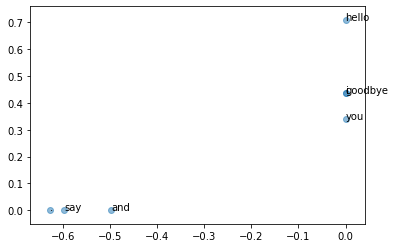

In [12]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id,0], U[word_id, 1]))
    
plt.scatter(U[:,0],U[:,1], alpha=0.5)
plt.show()

In [13]:
#2.4.4 PTB 데이터 셋 (펜 트리뱅크)
# 기법의 품질 층정하는 벤치마크로 주로 사용

import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기: ', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()

print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

말뭉치 크기:  929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [14]:
#2.4.5 PTB 데이터셋 평가
import sys
sys.path.append('..')
import numpy as np
#from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_Id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print("동시 발생 수 계산... ")
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('SVD 계산 ...')
try:
    from sklearn.utils.extmath import randomized_svd
    U,S,V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    U,S,V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size]
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)
    

동시 발생 수 계산... 
PPMI 계산 ...


<ipython-input-7-6ba377c25087>:10: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
<ipython-input-7-6ba377c25087>:10: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
SVD 계산 ...

[query] you
i: 0.7416968941688538
we: 0.6507484912872314
do: 0.6304545402526855
someone: 0.60810

In [15]:
#챕터 3 word2vec
#3.1 추론 기반 기법과 신경망
#3.1.2 개요 , 모델(맥락정보) -> 출현확률 출력, 추측하도록 학습
#3.1.3 신경망에서 단어 처리
'''
원핫 표현(원핫 벡터)
'''

import numpy as np
c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
h = np.matmul(c,W)
print(h)

[[ 0.137 -0.671 -1.665]]


In [16]:
#3.2 단순한 word2vec
#3.2.1 CBOW 모델의 추론 처리
#맥락(주변단어)-> 타깃(중앙단어)을 추측하는 용도의 신경망
#입력: 맥락, 출력: 단어의 분산표현
#은닉층은 입력이 여러개이면 전체 평균으로 값을 가지면 된다.
#가중치 W_(in)의 각 행에는 해당 단어의 분산표현이 담겨 있다고 볼 수 있다.


import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

#sample context data
c0 = np.array([1,0,0,0,0,0,0])
c1 = np.array([0,0,1,0,0,0,0])

#init weight 
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

#craete layers
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#forwarding
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

#맥락-> 분산표현(어떤단어가 중앙에 들어가는가)

[ 0.752  1.054 -1.084 -0.119  1.45   0.997 -1.545]


In [17]:
#3.2.2 CBOW 모델의 학습
#3.2.3 word2vec의 가중치와 분산 표현


In [18]:
import numpy as np

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts=[]
    
    for idx in range(window_size,len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)


In [20]:
#3.3 학습데이터 준비
import sys
sys.path.append('..')
from common.util import preprocess,create_contexts_target, convert_one_hot

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)


In [3]:
#3.4 CBOW 모델 구현
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        #가중치 초기화
        W_in = 0.01*np.random.randn(V,H).astype('f')
        W_out = 0.01*np.random.randn(H,V).astype('f')
        
        #계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        #모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        #인스턴스 변수에 단어의 분산표현을 저장한다.
        self.word_vecs = W_in
        
    def forward(self, contexts,target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1 ) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score,target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None
    
        

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 235 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 236 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 237 |  반복 1 / 2 | 시간 0[s] | 손실 1.22
| 에폭 238 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 239 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 240 |  반복 1 / 2 | 시간 0[s] | 손실 1.21
| 에폭 241 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 242 |  반복 1 / 2 | 시간 0[s] | 손실 1.20
| 에폭 243 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 244 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 245 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 246 |  반복 1 / 2 | 시간 0[s] | 손실 1.19
| 에폭 247 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 248 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 249 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 250 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 251 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 252 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 253 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 254 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 255 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 256 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 257 |  반복 1 / 2 | 시간 0[s] | 손실 1.16
| 에폭 258 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 259 |  반복 1

| 에폭 480 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 481 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 482 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 483 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 484 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 485 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 486 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 487 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 488 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 489 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 490 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 491 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 492 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 493 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 494 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 495 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 496 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 497 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 498 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 499 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 500 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 501 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 502 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 503 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 504 |  반복 1

| 에폭 745 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 746 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 747 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 748 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 749 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 750 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 751 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 752 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 753 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 754 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 755 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 756 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 757 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 758 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 759 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 760 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 761 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 762 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 763 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 764 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 765 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 766 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 767 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 768 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 769 |  반복 1

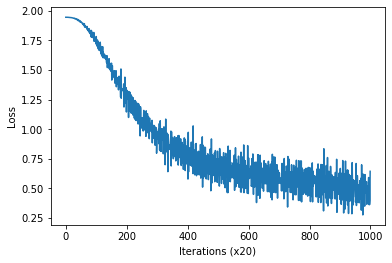

In [4]:
#3.4.1학습코드 구현
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
#from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus,word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts,vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target,max_epoch, batch_size)
trainer.plot()


In [5]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 0.9746254   0.83068645 -1.1444094   1.2879515  -1.5062823 ]
say [-1.422807   -1.3565297   0.32707536 -0.30406633  0.01729241]
goodbye [ 1.1141112   1.2304267  -0.7515445   0.52779543 -0.14120775]
and [-1.2861443 -1.2026747 -1.4558381  1.4565507 -1.3970528]
i [ 1.1092231   1.2672486  -0.7749974   0.5228816  -0.12293616]
hello [ 0.9602165   0.82788604 -1.1531681   1.2761947  -1.5173784 ]
. [-1.0749394 -1.0933237  1.2562603 -1.2600776  1.2767131]


In [ ]:
#3.5.1 CBOW 모델과 확률
#음의 로그 가능도 L= 1/T sigma^T_(t=1)(logP(w_t | w_(t-1), w_(t+1)))
#3.5.2 skip-gram 모델 (CBOW 를 역전 시킨 모델-> 타깃으로 맥락추측)
#손실함수: 모든 맥락별 손실을 구한후 다 더함(조건부 확률도 뒤집힘)
#CBOW와의 비교: 성능 더 좋음(저빈도 단어,유추), 허나 데이터 양 많으면 CBOW가 유리
#더어려운문제여서 성능이더좋아질 확률 커짐

#3.5.3 통계 VS 추론 기반
#우열 가릴 수 없음(연결되어 있어서)
